feature functions: "V_word"
Need to define a new feature function for 

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import bigrams
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pandas as pd 

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Getting the bigram counts (train data)

In [3]:
trainDF = pd.read_csv("C:\\Users\\matth\\Documents\\syracuse-university\\Spring2023\\Spring 2023\IST664\\final_project\\kagglemoviereviews\\corpus\\train.tsv", sep='\t')

stop_words = set(stopwords.words('english'))

stop_words.update(['.', ',', ' ', '', "'s", 'ca', "n't", '-rrb-', '``', '\\', '-lrb-', "'", '*', '--', '`', '...', "'ve"])

trainDF_phrases = trainDF['Phrase']

words = [nltk.word_tokenize(sentence) for sentence in trainDF_phrases]

words_flat = [word for sublist in words for word in sublist]

words_flat[:5]

words = [word.lower() for word in words_flat]

words = [word for word in words if word not in stop_words]

bigrams = list(bigrams(words))

bigram_counts = Counter(bigrams)

total_bigrams = len(bigrams) - 1
bigram_freqs = {bigram: count/total_bigrams for bigram, count in bigram_counts.items()}

top_bigrams = sorted(bigram_freqs.items(), key=lambda x: x[1], reverse=True)[:20]

pd.DataFrame(top_bigrams, columns=['bigram', 'relative frequency'])


,bigram,relative frequency
0,"(romantic, comedy)",0.000410
1,"(feel, like)",0.000323
2,"(new, york)",0.000316
3,"(subject, matter)",0.000283
4,"(running, time)",0.000279
5,"(special, effects)",0.000270
6,"(love, story)",0.000262
7,"(soap, opera)",0.000259
8,"(good, time)",0.000221
9,"(90, minutes)",0.000218


# 2. Getting bigram network graph (train data)

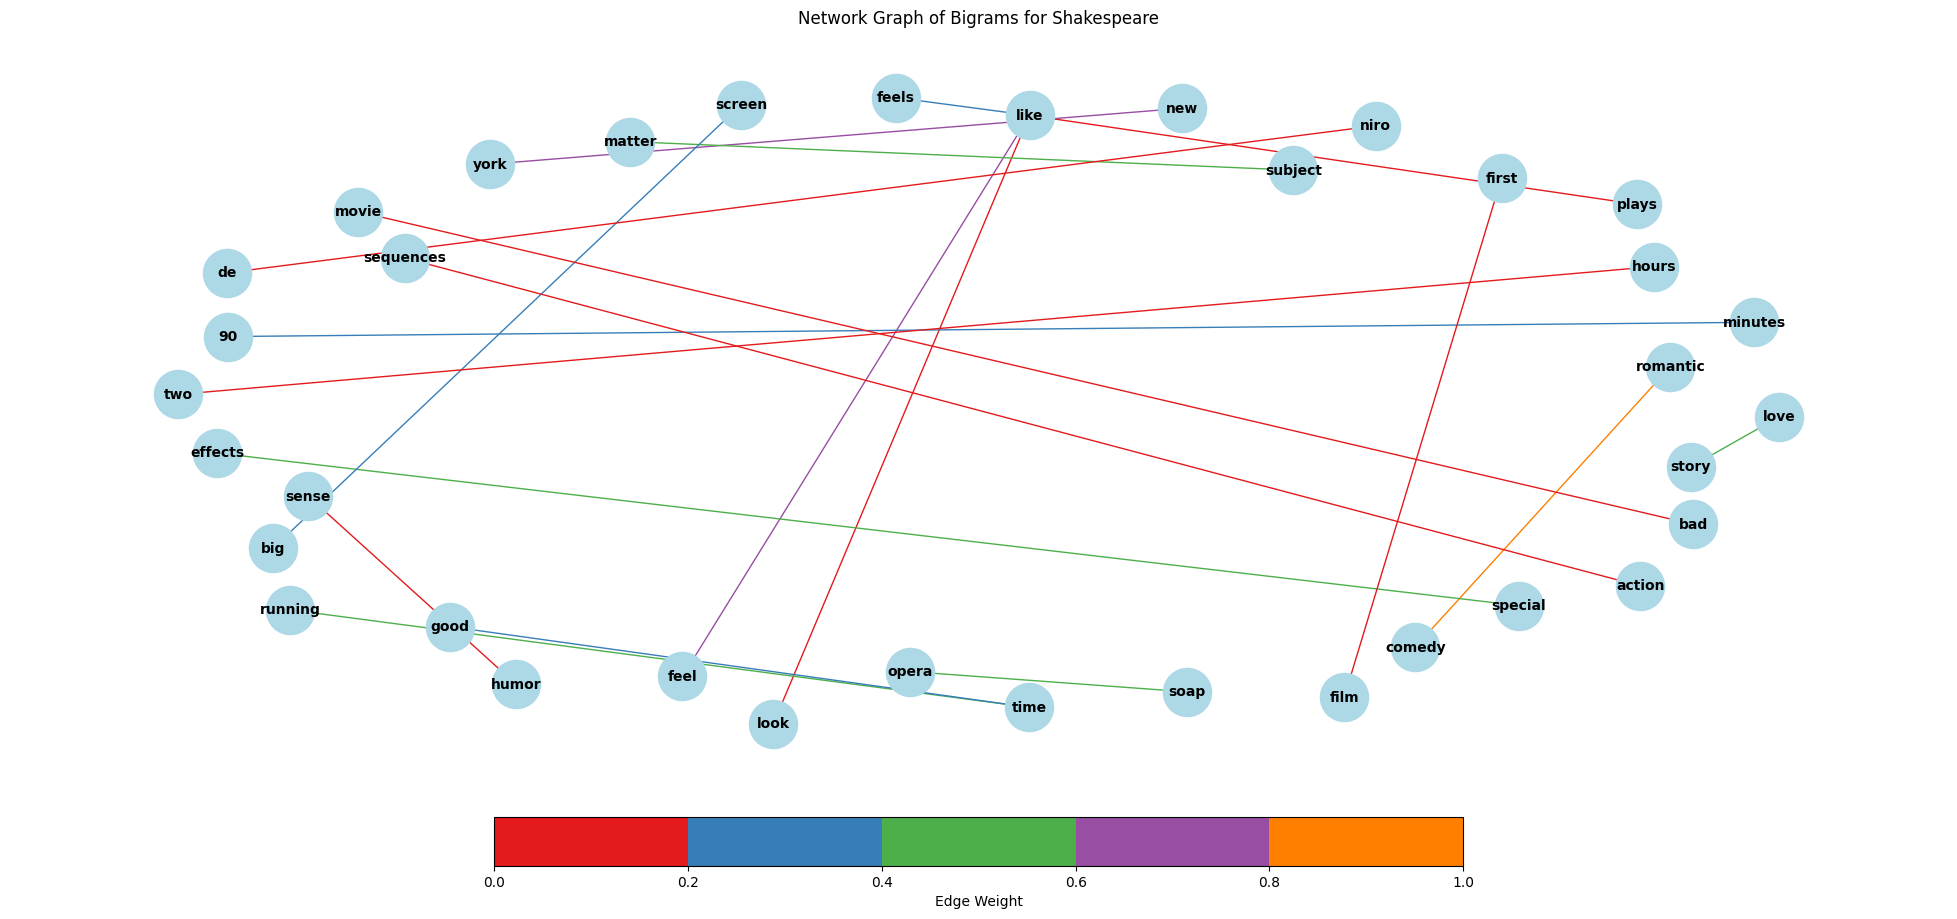

In [4]:
# Bigram frequency network graphs:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import numpy as np
from sklearn.preprocessing import MinMaxScaler

G1 = nx.Graph()

for bigram in top_bigrams:
    G1.add_edge(bigram[0][0], bigram[0][1], weight=bigram[1])

scaler = MinMaxScaler()
cmap = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00'])

weights1 = [G1[u][v]['weight'] for u, v in G1.edges()]
scaled_weights1 = scaler.fit_transform(np.array(weights1).reshape(-1,1))
min_weight1 = min(scaled_weights1)
max_weight1 = max(scaled_weights1)
edge_colors1 = [cmap((w - min_weight1) / (max_weight1 - min_weight1)) for w in scaled_weights1]

fig, ax = plt.subplots(figsize=(25, 12))

pos1 = nx.spring_layout(G1, k=1)
nx.draw(G1, pos=pos1, with_labels=True, font_size=10, node_color='lightblue', edge_color=edge_colors1, width=1, node_size=1200, font_weight='bold', ax=ax)
ax.set_title('Network Graph of Bigrams for Shakespeare')


sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_weight1, vmax=max_weight1))
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.03, aspect=20, shrink=0.5)
cbar.ax.set_xlabel('Edge Weight')

plt.show()

Explanation of graph: the 'edge weight' indicates the frequency of the bigram compared to others depicted.  As we can see, the bigram of 'romantic, comedy' appears the most out of all.  However, interestingly, the only shared word in the top 20 bigrams is the word 'like', with an edge weight varying between 0.1 -> 7.9 between the words 'feels', 'look', 'plays', and 'feel'.  In short, this diagram does not provide much insight, due to the nature of the text provided. 

# 3. Word Embeddings (Feature Extraction)

using the `gensim` package to extract word embeddings. 

- Using word embedding, we can determine which words have similar context or meaning with others in a body of text.
- In this case, we show how bigrams of words show similar word embedding vectors with one another.

In [5]:
review_df = pd.read_csv("kagglemoviereviews\\corpus\\train.tsv", sep = "\t")
unique_reviews = review_df.drop_duplicates(["SentenceId"], keep = "first")
unique_reviews = unique_reviews.reset_index()

unique_reviews


,index,PhraseId,SentenceId,Phrase,Sentiment
0,0,1,1,A series of escapades demonstrating the adage ...,1
1,63,64,2,"This quiet , introspective and entertaining in...",4
2,81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
3,116,117,4,A positively thrilling combination of ethnogra...,3
4,156,157,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...,...
8524,155984,155985,8540,... either you 're willing to go with this cla...,2
8525,155997,155998,8541,"Despite these annoyances , the capable Claybur...",2
8526,156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
8527,156031,156032,8543,The movie 's downfall is to substitute plot fo...,1


In [6]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, sent_tokenize

# Tokenize the sentences and words
sentences = [x for x in unique_reviews['Phrase']]
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Train a Word2Vec model
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# You can get the word vector for a particular word like this:

vector_feels = model.wv['feels']

vector_plays = model.wv['plays']

vector_look = model.wv['look']

vector_feel = model.wv['feel']

vector_like = model.wv['like']

vector_film = model.wv['film']

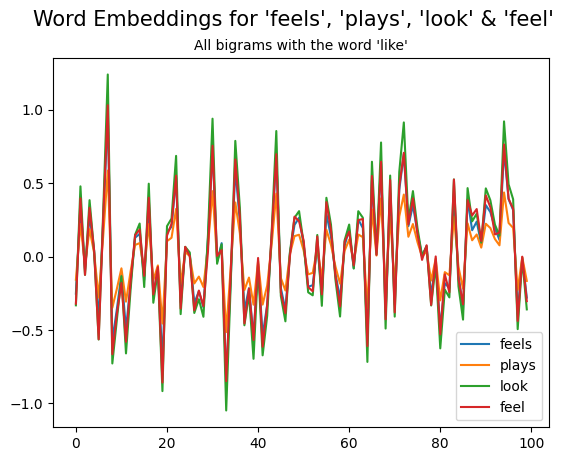

In [7]:
import matplotlib.pyplot as plt

# Assume you have 5 lists as follows:
list1 = vector_feels
list2 = vector_plays
list3 = vector_look
list4 = vector_feel

# Create an array for the x values
x = range(len(list1))

# Plot each list with a label
plt.plot(x, list1, label='feels')
plt.plot(x, list2, label='plays')
plt.plot(x, list3, label='look')
plt.plot(x, list4, label='feel')

# Add a legend
plt.legend()
plt.suptitle("Word Embeddings for 'feels', 'plays', 'look' & 'feel'", size=15)
plt.title("All bigrams with the word 'like'", size=10)

# Show the plot
plt.show()

In [8]:
print(list1)

[-0.2524582   0.34652957 -0.08872052  0.27987814  0.0375572  -0.43598017
  0.23785715  0.96714354 -0.57245487 -0.35763228 -0.12037256 -0.49453694
 -0.18553065  0.1280251   0.15505058 -0.1594293   0.36490786 -0.26273775
 -0.08726814 -0.7220684   0.1646652   0.2032758   0.537536   -0.311258
  0.04639724  0.01446981 -0.3162815  -0.2360986  -0.34579894  0.11971023
  0.7372908  -0.03808507  0.09124901 -0.8355768  -0.14421049  0.6015769
  0.23653942 -0.36553726 -0.21533315 -0.5435255  -0.05071082 -0.53587973
 -0.3277162   0.1317838   0.6939886  -0.21486819 -0.36111686  0.02484609
  0.21541998  0.26367342  0.08574471 -0.20555207 -0.19503206  0.07889336
 -0.26247427  0.2913313   0.13647361 -0.11971741 -0.28638163  0.07623198
  0.18232827 -0.07933652  0.25275445  0.1939985  -0.56181747  0.51675266
  0.02957659  0.63219386 -0.3827109   0.43278658 -0.32798848  0.4537933
  0.6987429   0.20687643  0.34978026  0.15997803  0.00882278  0.06617725
 -0.26455525 -0.0340993  -0.48642668 -0.18095699 -0.214

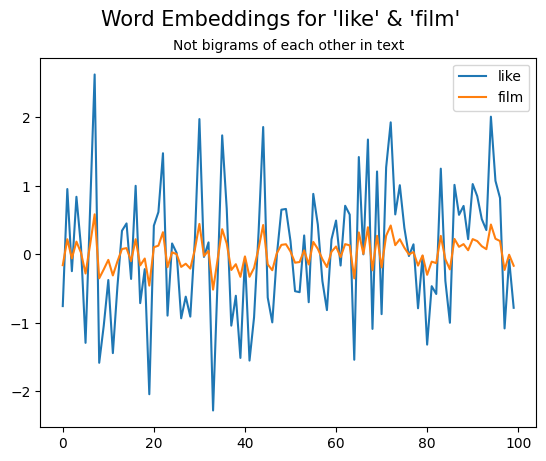

In [9]:
import matplotlib.pyplot as plt

# Assume you have 5 lists as follows:
list1 = vector_like
list5 = vector_film

# Create an array for the x values
x = range(len(list1))

# Plot each list with a label
plt.plot(x, list1, label='like')
plt.plot(x, list2, label='film')

# Add a legend
plt.legend()
plt.suptitle("Word Embeddings for 'like' & 'film'", size=15)
plt.title("Not bigrams of each other in text", size=10)

# Show the plot
plt.show()

- This technique can be used in a multitude of ways, including:
    - Text Classification
    - Machine translation
    - Text Summarization
    - Question answering
    - Semantic Search
    - Recommendation systems


- A function to use in this kind of text to get word embedding vectors as a feature would be as follows:

In [10]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt

def word_embeddings(df: pd.DataFrame, col_name: str, word1: str, word2: str):
    sentences = [x for x in df[col_name]]
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

    # Train a Word2Vec model
    model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

    # You can get the word vector for a particular word like this:

    vector_word1 = model.wv[word1]

    vector_word2 = model.wv[word2]

    list1 = vector_word1
    list2 = vector_word2

    x = range(len(list1))

    # Plot each list with a label
    plt.plot(x, list1, label=f'{word1}')
    plt.plot(x, list2, label=f'{word2}')


    plt.legend()
    plt.suptitle(f"Word Embedding Vectors for '{word1}' & '{word2} ", size=15)
    
    plt.show()

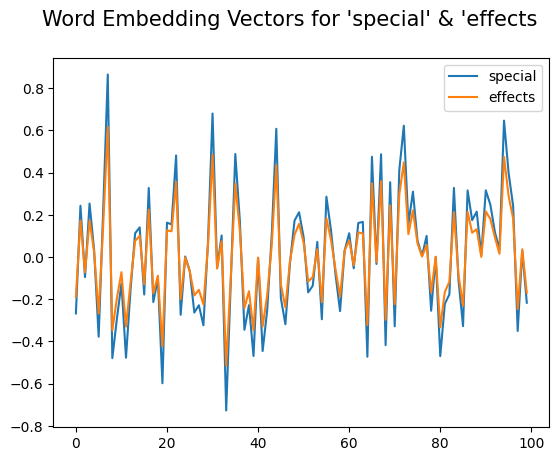

In [11]:
word_embeddings(unique_reviews, 'Phrase', 'special', 'effects')

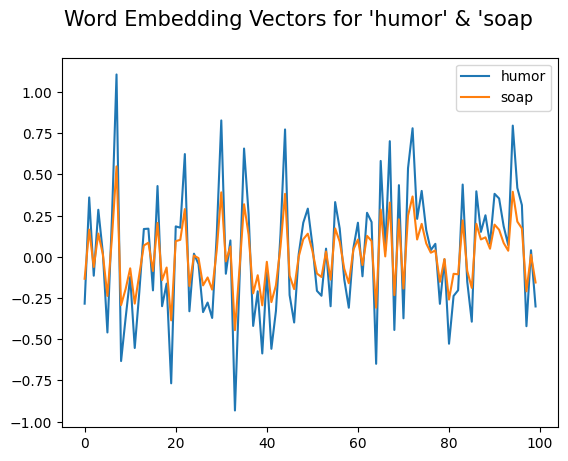

In [12]:
word_embeddings(unique_reviews, 'Phrase', 'humor', 'soap')



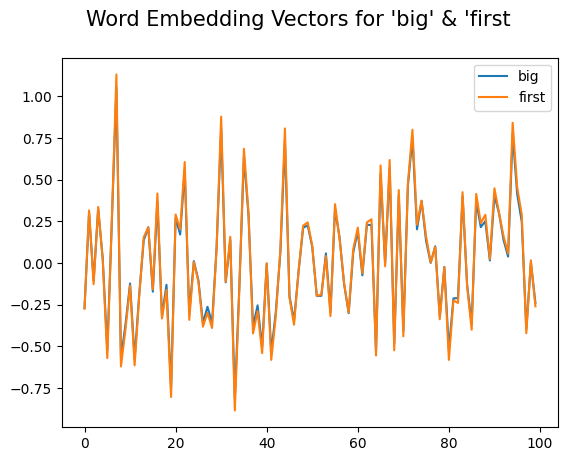

In [13]:
word_embeddings(unique_reviews, 'Phrase', 'big', 'first')

In [30]:
review_df = pd.read_csv("kagglemoviereviews\\corpus\\train.tsv", sep = "\t")
unique_reviews = review_df.drop_duplicates(["SentenceId"], keep = "first")
unique_reviews = unique_reviews.reset_index()


from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, sent_tokenize

# Tokenize the sentences and words
sentences = [x for x in unique_reviews['Phrase']]
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Train a Word2Vec model
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def get_avg_word2vec(sentence_list, vector, generate_missing=False, k=100):
    if len(sentence_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in sentence_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in sentence_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, df, generate_missing=False):
    embeddings = unique_reviews['Phrase'].apply(lambda x: get_avg_word2vec(x, vectors, 
                                                            generate_missing=generate_missing))
    return list(embeddings)

# First, tokenize the reviews
unique_reviews['Phrase'] = unique_reviews['Phrase'].apply(lambda x: word_tokenize(x))

# Generate the embeddings
embeddings = get_word2vec_embeddings(model.wv, unique_reviews)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(embeddings, unique_reviews['Sentiment'], 
                                                    test_size=0.2, random_state=40)

# Training a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       224
           1       0.29      0.48      0.36       441
           2       0.33      0.01      0.02       298
           3       0.33      0.64      0.43       500
           4       0.38      0.02      0.04       243

    accuracy                           0.31      1706
   macro avg       0.27      0.23      0.17      1706
weighted avg       0.29      0.31      0.23      1706



c:\.virtualenvs\ist664env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\.virtualenvs\ist664env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\.virtualenvs\ist664env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 i

In [33]:
review_df = pd.read_csv("kagglemoviereviews\\corpus\\train.tsv", sep = "\t")
unique_reviews = review_df.drop_duplicates(["SentenceId"], keep = "first")
unique_reviews = unique_reviews.reset_index()


from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, sent_tokenize

# Tokenize the sentences and words
sentences = [x for x in unique_reviews['Phrase']]
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Train a Word2Vec model
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = [get_avg_word2vec(x, vectors, generate_missing=generate_missing) for x in clean_questions]
    return embeddings

# Assuming 'model' is your Word2Vec model
embeddings = get_word2vec_embeddings(model.wv, tokenized_sentences)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(embeddings, unique_reviews['Sentiment'], 
                                                    test_size=0.2, random_state=40)

# Convert list of vectors to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Training a Random Forest Classifier model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predicting
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))




              precision    recall  f1-score   support

           0       0.12      0.02      0.04       224
           1       0.30      0.42      0.35       441
           2       0.20      0.17      0.18       298
           3       0.30      0.37      0.33       500
           4       0.21      0.14      0.17       243

    accuracy                           0.27      1706
   macro avg       0.23      0.23      0.21      1706
weighted avg       0.24      0.27      0.25      1706



In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Here's your function for generating average Word2Vec embeddings
def get_avg_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['Phrase'].apply(lambda x: get_avg_word2vec(x, vectors, 
                                                            generate_missing=generate_missing))
    return list(embeddings)

# Assuming 'model' is your Word2Vec model
embeddings = get_word2vec_embeddings(model.wv, unique_reviews)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(embeddings, unique_reviews['Sentiment'], 
                                                    test_size=0.2, random_state=40)

# Convert list of vectors to numpy arrays
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

# Training a Random Forest Classifier model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predicting
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (188,) + inhomogeneous part.

# Interpretation of Results:

From the classification report above, we can clearly see that using this word embeddings model was most useful for predicting a rating of `1` (F1 = 0.36, Support = 441) or `3` (F1 = 0.44, Support = 500) in each title.  The classification of `3` also had one of the highest precision scores (0.33), but a classification of `4` had the highest precision (0.36), but with the second lowest support value (243).

Overall, the model had an overall F1 score of 0.32, which is relatively poor.  I would not recommend solely using word embeddings for this kind of classification prediction. I t may, however, be useful in conjuction with other classification methods.